In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/glove-global-vectors-for-word-representation/glove.twitter.27B.200d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.twitter.27B.100d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.twitter.27B.50d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.twitter.27B.25d.txt
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/test.csv


In [3]:
# Import datasets
import pandas as pd
submission = pd.read_csv("../input/nlp-getting-started/sample_submission.csv")
test = pd.read_csv("../input/nlp-getting-started/test.csv")
train = pd.read_csv("../input/nlp-getting-started/train.csv")

In [4]:
# Change Pandas Setting to show more columns and rows
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 100)

# EDA

In [48]:
# Check size of our data
print(f'Training Set has {train.shape[0]} rows and {train.shape[1]} columns which are {train.columns.values}.')
print(f'\nTest Set has {test.shape[0]} rows and {test.shape[1]} columns which are {test.columns.values}.')


Training Set has 7613 rows and 6 columns which are ['id' 'keyword' 'location' 'text' 'target' 'target_mean'].

Test Set has 3263 rows and 4 columns which are ['id' 'keyword' 'location' 'text'].


In [23]:
# Missing Value
print('Train Set % Missing Values:\n',(train.isnull().sum()*100/len(train)).sort_values(ascending=False))
print('Test Set % Missing Values:\n',(test.isnull().sum()*100/len(test)).sort_values(ascending=False))
print(f'Unique values in Location: {train["location"].nunique()} over {train["location"].notnull().sum()} nonmissing observations in Train Set and {test["location"].nunique()} over {test["location"].notnull().sum()} nonmissing observations in Test Set' )
print(f'Unique values in Location: {train["keyword"].nunique()} over {train["keyword"].notnull().sum()} nonmissing observations in Train Set and {test["keyword"].nunique()} over {test["keyword"].notnull().sum()} nonmissing observations in Test Set' )

# Location has about 33% observations without infomation. There are too many unique values comapring to number of observation. Since location is less likely to have correlation with real or fake disaster tweets, it is safe to remove it from the analysis.

Train Set % Missing Values:
 location    33.272035
keyword      0.801261
target       0.000000
text         0.000000
id           0.000000
dtype: float64
Test Set % Missing Values:
 location    33.864542
keyword      0.796813
text         0.000000
id           0.000000
dtype: float64
Unique values in Location: 3341 over 5080 nonmissing observations in Train Set and 1602 over 2158 nonmissing observations in Test Set
Unique values in Location: 221 over 7552 nonmissing observations in Train Set and 221 over 3237 nonmissing observations in Test Set


### Keyword Feature

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt

diverging_colors = sns.color_palette("RdBu", 10)
sns.set_palette(diverging_colors)

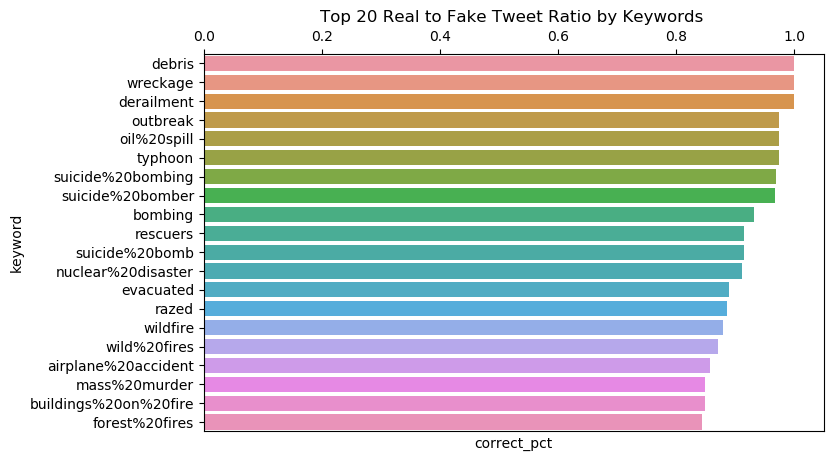

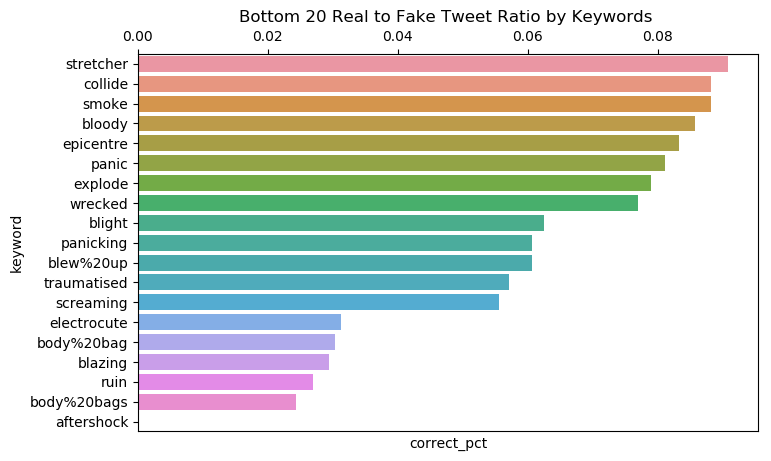

In [106]:
%matplotlib inline
# Compute and sort real/fake ratio for each keyword
keyword_df = train[['id','keyword','target']].copy()
keyword_df['correct_pct'] = keyword_df.groupby('keyword')['target'].transform('mean')
keyword_df = keyword_df.drop_duplicates('keyword').sort_values('correct_pct', ascending=False)

# Plot top 50 keywords
fig = plt.figure(figsize=(8, 5), dpi=100)

ax = sns.barplot(y='keyword', x='correct_pct',data=keyword_df.iloc[:20])
ax.xaxis.set_ticks_position('top')
ax.set_title('Top 20 Real to Fake Tweet Ratio by Keywords ')
plt.show()

fig = plt.figure(figsize=(8, 5), dpi=100)
ax = sns.barplot(y='keyword', x='correct_pct',data=keyword_df.iloc[-20:])
ax.xaxis.set_ticks_position('top')
ax.set_title('Bottom 20 Real to Fake Tweet Ratio by Keywords ')
plt.show()

# Cleaning Up datasets

In [ ]:
# Import NLTK package and Regex for cleaning
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import wordpunct_tokenize
import re
  
lemmatizer = WordNetLemmatizer().lemmatize   
stop_words = set(stopwords.words('english')) 
  

In [ ]:
# Remove puntuation, url links, remove stopwords then tokenize text
def clean_text(text, fix_spelling=False):
    text = re.sub(r'http.*?( |$)', '', text)
    text = re.sub(r'@.*?( |$)', '', text)
    text = re.sub(r'[^(a-zA-Z)\s]','  ',text)
    #text = p.clean(text)
    text = text.lower()
    tokens = word_tokenize(text)
    if fix_spelling:
        tokenized = [lemmatizer(SpellChecker().correction(w)) for w in tokens if not w in stop_words]
    else:
        tokenized = [lemmatizer(w) for w in tokens if not w in stop_words]
    return ' '.join(tokenized)

In [ ]:
# Create a function to transform a dataset to usable format
# Drop irrelevant columns, apply the clean_text function to the text column, seperate feature and label columns
# Return X, y
def transform_data(dataset, text_col, label):
    data = dataset.drop(columns=['keyword','location'])
    data['clean_text'] = data[text_col].apply(clean_text)
    x = data['clean_text']
    if label in data:
        y = data[label]
    else:
        y = None
    return x, y

In [ ]:
# Transform train and test dataframe
X, y = transform_data(train, 'text','target')
X_test, _ = transform_data(test, 'text','target')

In [ ]:
# Test cleaning process
for i in np.random.randint(train.shape[0], size=5):
    print(f'Raw: {train["text"][i]}.\nCleaned: {X[i]}\n')


In [ ]:
# Split X into train and validation sets

from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state = 777, test_size = 0.2)

## Preparing for deep learning

In [ ]:
# Hyperparameters
vocab_size = 100000    # max no. of words for tokenizer
max_length = 200 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
embedding_dim = 100      # embedding dimensions for word vectors (word2vec/GloVe)
GLOVE_DIR = "../input/glove-global-vectors-for-word-representation/glove.twitter.27B."+str(embedding_dim)+"d.txt"

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def padding_text(X,vocab_size,max_length,padding_type='post',trunc_type='post'):
    corpus = X.values.tolist()
    #print(corpus[:20])
    X_seq = tokenizer.texts_to_sequences(corpus)
    X_padd = pad_sequences(X_seq, maxlen= max_length, padding=padding_type, truncating=trunc_type)
    return X_padd

# Create corpus of all tweets in the train set
corpus_train = X_train.values.tolist()
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<oov>')
tokenizer.fit_on_texts(corpus_train)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

# Map words to numbers
# Padding Text
X_train_padd = padding_text(X_train,vocab_size,max_length)
X_valid_padd = padding_text(X_valid,vocab_size,max_length)
X_test_padd = padding_text(X_test,vocab_size,max_length)

print('Shape of train set tensor:', X_train_padd.shape)
print('Shape of train label tensor:', y_train.shape)
print('Shape of validation set tensor:', X_valid_padd.shape)
print('Shape of validation label tensor:', y_valid.shape)

In [ ]:
embeddings_index = {}
f = open(GLOVE_DIR)
print('Loading GloVe from:', GLOVE_DIR,'...', end='\n')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n\nProceeding with Embedding Matrix...", end="\n")

embedding_matrix = np.random.random((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print("Completed!")

In [ ]:
# Create F1 score function for model metric

import keras.backend as K

def f1_score_keras(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Bidirectional, Dropout, Dense, LSTM
#from tensorflow import keras
# Model Definition with LSTM

def create_model():
    model = tf.keras.Sequential([
        Embedding(len(word_index) + 1, embedding_dim,weights = [embedding_matrix],
                                  input_length=max_length, trainable=False, name = 'embeddings'),
        Bidirectional(LSTM(64)),
        Dropout(0.2),
        Dense(50, activation='relu'),
        Dropout(0.2),

        Dense(1, activation='sigmoid')  # remember this is a binary clasification
    ])
    return model

model = create_model()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=[f1_score_keras])
#######

In [ ]:
import time
start_time = time.time()

num_epochs = 10
history = model.fit(X_train_padd, y_train, epochs=num_epochs, validation_data=(X_valid_padd, y_valid))

final_time = (time.time()- start_time)/60
print(f'The time in minutes: {final_time}')

In [ ]:
# Model Validation

In [ ]:
model_loss = pd.DataFrame(model.history.history)
model_loss.head()

In [ ]:
model_loss[['f1_score_keras','val_f1_score_keras']].plot(ylim=[0,1]);

In [ ]:
model.evaluate(X_valid_padd, y_valid)

In [ ]:
from sklearn.metrics import f1_score
pred = model.predict_classes(X_valid_padd)   # predict_ clases because is classification problem with the split test
f1_score(y_valid, pred)

In [ ]:
##  Hyperparameters Optimization using Bayesian OP

In [ ]:
from bayes_opt import BayesianOptimization
from keras.optimizers import Adam

def create_model():
    model = tf.keras.Sequential([
        Embedding(len(word_index) + 1, embedding_dim,weights = [embedding_matrix],
                                  input_length=max_length, trainable=False, name = 'embeddings'),
        Bidirectional(LSTM(64)),
        Dropout(0.2),
        Dense(50, activation='relu'),
        Dropout(0.2),

        Dense(1, activation='sigmoid')  # remember this is a binary clasification
    ])
    return model

def model_eval(learning_rate, num_input_nodes, adam_decay,num_dense_layers,num_dense_nodes, drop_out,lstm_nodes,max_length):#, embedding_dim, vocab_size,):

    X_train_padd = padding_text(X_train,int(vocab_size),int(max_length))
    X_valid_padd = padding_text(X_valid,int(vocab_size),int(max_length))
     
    model = tf.keras.Sequential([
        Embedding(len(word_index) + 1, embedding_dim,weights = [embedding_matrix],
                    input_length=int(max_length), trainable=False, name = 'embeddings'),
        Bidirectional(LSTM(int(lstm_nodes))),
        Dropout(drop_out)
        ])

    for i in range(int(num_dense_layers)):
        name = 'layer_dense_{0}'.format(i+1)
        model.add(Dense(int(num_dense_nodes),
                 activation='relu',
                        name=name
                 ))
        model.add(Dropout(drop_out))
    
    model.add(Dense(1, activation='sigmoid'))
        
    #setup our optimizer and compile
    adam = Adam(lr=learning_rate, decay= adam_decay)
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=[f1_score_keras])
    
    num_epochs = 5
    history = model.fit(X_train_padd, y_train, epochs=num_epochs, validation_data=(X_valid_padd, y_valid), verbose=1)

    pred = model.predict_classes(X_valid_padd) 
    f1_val = f1_score(y_valid, pred)
    return f1_val

In [ ]:
max_length

In [ ]:
Model_BO = BayesianOptimization(model_eval, {'learning_rate':(1e-4,1e-2), 'num_dense_layers':(1,5),
                                            'num_input_nodes':(1,512), 'num_dense_nodes':(1,100), 
                                            'adam_decay':(1e-6,1e-2), 'drop_out':(0,0.9), 'lstm_nodes':(64,200),
                                             'max_length':(1,200)
                                            })

In [ ]:
Model_BO.maximize(n_iter=2, init_points=2)

In [ ]:
model_eval(0.001,100,0.1,10,50,0.2,64,200)